# Dependencies

In [1]:
%matplotlib ipympl

In [2]:
from copy import deepcopy

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi
from vpython import *

/home/fridge/robot/venv/lib/python3.12/site-packages/vpython/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


<IPython.core.display.Javascript object>

# Forward/Inverse Kinematics

In [3]:
def fk(theta1, theta2, d3):
    return np.transpose(
        [
            np.array(
                [
                    0.5 * np.cos(theta1) + 0.5 * np.cos(theta1 + theta2),
                    0.5 * np.sin(theta1) + 0.5 * np.sin(theta1 + theta2),
                    1 - d3,
                ]
            )
        ]
    )


def ik(x, y, z):
    c2 = (x**2 + y**2 - 0.5**2 - 0.5**2) / (2 * 0.5**2)
    s2 = np.sqrt(1 - c2**2)
    th1 = np.atan2(x, y) - np.atan2(0.5 + 0.5 * c2, 0.5 * s2)
    th2 = np.acos(2 * (x**2 + y**2) - 1)
    d = 1 - z
    return np.transpose([np.array([th1, th2, d])])

# Jacobian

In [4]:
def J(theta1, theta2, d3):
    return np.transpose(
        np.array(
            [
                [
                    -0.5 * np.sin(theta1) - 0.5 * np.sin(theta1 + theta2),
                    -0.5 * np.sin(theta1 + theta2),
                    0,
                ],
                [
                    0.5 * np.cos(theta1) + 0.5 * np.cos(theta1 + theta2),
                    0.5 * np.cos(theta1 + theta2),
                    0,
                ],
                [0, 0, -1],
            ]
        )
    )


def Ji(theta1, theta2, d3):
    return np.transpose(
        np.array(
            [
                [
                    2.0 * np.cos(theta1 + theta2) / np.sin(theta2),
                    2.0 * np.sin(theta1 + theta2) / np.sin(theta2),
                    0,
                ],
                [
                    -(2.0 * np.cos(theta1) + 2.0 * np.cos(theta1 + theta2))
                    / np.sin(theta2),
                    -(2.0 * np.sin(theta1) + 2.0 * np.sin(theta1 + theta2))
                    / np.sin(theta2),
                    0,
                ],
                [0, 0, -1],
            ]
        )
    )

# Dynamics

In [5]:
def idynamics(theta1, theta2, d3, dtheta1, dtheta2, dd3, ddtheta1, ddtheta2, ddd3):
    return np.array(
        [
            [
                -3.0 * np.sin(theta2) * dtheta1 * dtheta2
                - 1.5 * np.sin(theta2) * dtheta2**2
                + 3.0 * np.cos(theta2) * ddtheta1
                + 1.5 * np.cos(theta2) * ddtheta2
                + 4.25 * ddtheta1
                + 1.5 * ddtheta2
            ],
            [
                1.5 * np.sin(theta2) * dtheta1**2
                + 1.5 * np.cos(theta2) * ddtheta1
                + 1.5 * ddtheta1
                + 1.5 * ddtheta2
            ],
            [2.0 * ddd3 - 19.6],
        ]
    ).reshape((3, 1))

In [6]:
def moving_average(data, window_size):
    # Moving average function, mostly used to filter down the torque and tracking error as they have a large amount of oscillation.
    # Not used for any actual calculation, just for plotting
    return np.convolve(data, np.ones(window_size) / window_size, mode="same")

In [7]:
def path1(t):
    # straight line from p1 to p2
    rpoint1 = fk(-pi / 6, -pi / 2, 0)
    rpoint2 = fk(pi / 6, pi / 2, 1)
    return (rpoint2 - rpoint1) * t / 10 + rpoint1

In [8]:
def path2(t):
    # straight line from p1 to pi then from pi to p2
    t /= 5
    rpoint1 = fk(-pi / 6, -pi / 2, 0)
    rpoint2 = fk(pi / 6, pi / 2, 1)
    ipoint = np.array([0.5, 0, 0.75]).reshape((3, 1))
    if t <= 1:
        return (ipoint - rpoint1) * t + rpoint1
    t -= 1
    return (rpoint2 - ipoint) * t + ipoint

In [9]:
def path3(t):
    # Cubic spline from p1 to pi then from pi to p2
    f = 2  # speed at intermediate point ipoint. Velocities at initial and end points are assumed to be 0
    t /= 5
    rpoint1 = fk(-pi / 6, -pi / 2, 0)
    rpoint2 = fk(pi / 6, pi / 2, 1)
    ipoint = np.array([0.5, 0, 0.75]).reshape((3, 1))
    if t <= 1:
        return (
            (2 * rpoint1 - 2 * ipoint + f) * t**3
            + (3 * ipoint - 3 * rpoint1 - f) * t**2
            + rpoint1
        )
    t -= 1
    return (
        (2 * ipoint - 2 * rpoint2 + f) * t**3
        + (3 * rpoint2 - 3 * ipoint - 2 * f) * t**2
        + f * t
        + ipoint
    )

In [22]:
# Specify path here
paths = [path1, path2, path3]
path = path3

In [23]:
# Simulation and control loop
t = np.linspace(0, 10, 1000)  # time (10 seconds)
ni = 50  # number of control loop iterations
dt = (t[1] - t[0]) / ni

Kp = 10.0
Ki = 0.5
Kd = 0.05
previous_dq = np.zeros((3, 1))
integral = np.zeros((3, 1))
xd = fk(-pi / 6, -pi / 2, 0)  # Desired rpoint
q = np.array([-pi / 6, -pi / 2, 0])  # Current rpoint
q_prev = np.zeros((3, 1))
dq_prev = np.zeros((3, 1))

window_size = len(t) // 20  # Window size for nicer plots

record = []
Os = []
ts = []
MSErecord = []
torques = []
speeds = []
powers = []

for i in t:
    xd = path(i).reshape((3, 1))
    for j in range(ni):
        ts.append(i + j * dt)
        record.append(deepcopy(q))
        x = fk(*q)
        e = xd - x
        MSErecord.append(np.sqrt(np.transpose(e) @ e))
        dq = Ji(*q) @ e
        # Proportional
        P = Kp * dq

        # Integral
        integral += dq * dt
        I = Ki * integral

        # Derivative
        derivative = (dq - previous_dq) / dt
        D = Kd * derivative

        O = P + I + D
        Os.append(O)
        previous_dq = dq

        q_prev = deepcopy(q)
        q += np.transpose(O)[0] * dt
        dq_curr = np.transpose(O)[0]
        ddq_curr = (dq_curr - dq_prev) / dt
        dq_curr_flat = dq_curr.ravel()
        dq_prev_flat = dq_prev.reshape((3,))
        ddq_curr = np.subtract(dq_curr_flat, dq_prev_flat)
        dq_prev = deepcopy(dq_curr)
        torq = idynamics(*q, *dq_curr, *ddq_curr)
        torques.append(deepcopy(torq))
        power = np.abs(np.dot(np.transpose(torq), dq_curr.reshape((3, 1))))
        powers.append(power)

In [12]:
# Total energy consumed
print(
    f"The total energy consumed on the selected path is {sum(dt * np.array(powers)).reshape((1,))[0]} Joules"
)

The total energy consumed on the selected path is 19.180309616142637 Joules


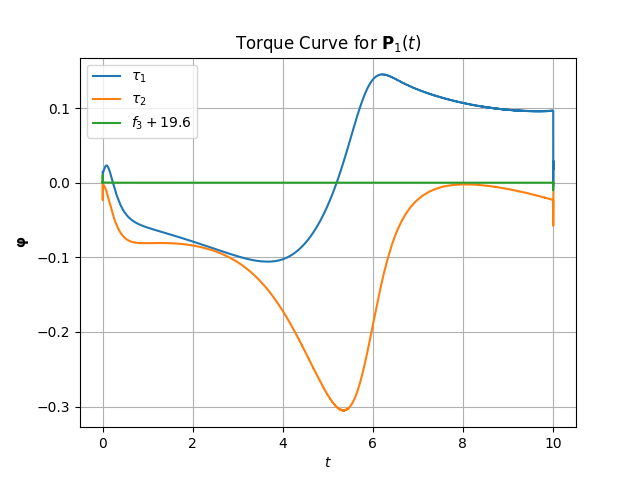

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

torque1s = np.array([i[0] for i in torques[1:]]).reshape((len(ts) - 1,))
torque2s = np.array([i[1] for i in torques[1:]]).reshape((len(ts) - 1,))
torque3s = np.array([i[2] + 19.6 for i in torques[1:]]).reshape((len(ts) - 1,))

ax.plot(ts[1:], moving_average(torque1s, window_size), label=r"$\tau_1$")
ax.plot(ts[1:], moving_average(torque2s, window_size), label=r"$\tau_2$")
ax.plot(ts[1:], moving_average(torque3s, window_size), label=r"$f_3 + 19.6$")
ax.legend()

ax.grid(True)
ax.set_title(fr"Torque Curve for $\mathbf{'{P}'}_{paths.index(path)+1}(t)$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathbf{\varphi}$")

plt.show()

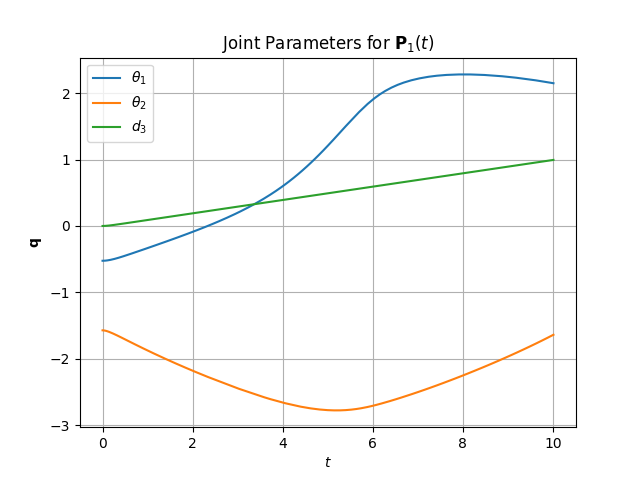

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

theta1s = [i[0] for i in record]
theta2s = [i[1] for i in record]
d3s = [i[2] for i in record]

ax.plot(ts, theta1s, label=r"$\theta_1$")
ax.plot(ts, theta2s, label=r"$\theta_2$")
ax.plot(ts, d3s, label=r"$d_3$")
ax.legend()

ax.grid(True)
ax.set_title(fr"Joint Parameters for $\mathbf{'{P}'}_{paths.index(path)+1}(t)$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathbf{q}$")


# ax.set_box_aspect([2, 2, 0.75])

plt.show()

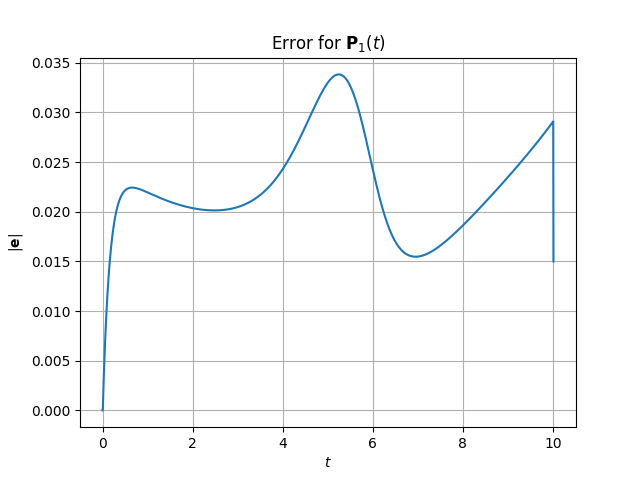

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(ts, moving_average(np.array(MSErecord).reshape(len(ts)), window_size))
# ax.plot(ts, theta2s)
# ax.plot(ts, d3s)

# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_zlim([0, 0.75])

ax.grid(True)
ax.set_title(fr"Error for $\mathbf{'{P}'}_{paths.index(path)+1}(t)$")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$|\mathbf{e}|$")

# ax.set_box_aspect([2, 2, 0.75])

plt.show()

# Visualization

In [16]:
def RPoints(theta1, theta2, d3):
    # Position
    return [
        [0, 0, 1],
        [0.5 * np.cos(theta1), 0.5 * np.sin(theta1), 1],
        [
            0.5 * np.cos(theta1) + 0.5 * np.cos(theta1 + theta2),
            0.5 * np.sin(theta1) + 0.5 * np.sin(theta1 + theta2),
            1,
        ],
        [
            0.5 * np.cos(theta1) + 0.5 * np.cos(theta1 + theta2),
            0.5 * np.sin(theta1) + 0.5 * np.sin(theta1 + theta2),
            1 - d3,
        ],
    ]

In [17]:
def shiftyz(l):
    return l[0], l[2], l[1]

In [24]:
scene = canvas(title="SCARA Robot", width=1080, height=720)

joint_thickness = 0.05 / 2
joint_radius = 0.1 / 2
end_effector_radius = 0.075 / 2

local_record = deepcopy(record[::ni])

base = cylinder(
    pos=vector(0, -0.5, 0), axis=vector(0, -0.1, 0), radius=0.5, color=color.gray(0.5)
)
vertical_base = cylinder(
    pos=vector(0, -0.5, 0),
    axis=vector(0, 0.5 + 1, 0),
    radius=joint_thickness,
    color=color.gray(0.5),
)

theta1, theta2, d3 = local_record[0]


# Populate the lists
joints = []
spheres = []

curve_def = [path(t).reshape((3,)) for t in np.linspace(0, 10, 1000)]
curve_def = [vector(*shiftyz(t)) for t in curve_def]

path_plot = curve(
    pos=curve_def, color=color.purple, radius=end_effector_radius / 2, emissive=True
)


def init_robot(theta1, theta2, d3):
    pos = RPoints(theta1, theta2, d3)
    for i in range(len(pos) - 2):
        current = pos[i]
        diff = [m - n for n, m in zip(pos[i], pos[i + 1])]
        joints.append(
            cylinder(
                pos=vector(*shiftyz(current)),
                axis=vector(*shiftyz(diff)),
                radius=joint_thickness,
                color=color.blue,
            )
        )
        spheres.append(
            sphere(pos=vector(*shiftyz(current)), radius=joint_radius, color=color.red)
        )

    joints.append(
        cylinder(
            pos=vector(*shiftyz(pos[-1])),
            axis=vector(0, 1, 0),
            radius=joint_thickness,
            color=color.blue,
        )
    )
    spheres.append(
        sphere(pos=vector(*shiftyz(pos[-2])), radius=joint_radius, color=color.red)
    )
    spheres.append(
        sphere(
            pos=vector(*shiftyz(pos[-1])),
            radius=end_effector_radius,
            color=color.green,
            make_trail=True,
            trail_radius=end_effector_radius / 2,
            interval=3,
            retain=10,
        )
    )


def update_robot(theta1, theta2, d3):
    pos = RPoints(theta1, theta2, d3)
    for i in range(len(pos) - 2):
        current = pos[i]
        diff = [m - n for n, m in zip(pos[i], pos[i + 1])]
        # print(diff)
        joints[i].pos = vector(*shiftyz(current))
        joints[i].axis = vector(*shiftyz(diff))
        spheres[i].pos = vector(*shiftyz(current))
    # joints[i].pos = vector(*shiftyz(pos[-2]))
    # joints[i].axis = vector(*shiftyz(diff))
    joints[-1].pos = vector(*shiftyz(pos[-1]))
    spheres[-2].pos = vector(*shiftyz(pos[-2]))
    spheres[-1].pos = vector(*shiftyz(pos[-1]))


loop = 0
init_robot(theta1, theta2, d3)
while True:
    rate(30)
    current_pos = local_record[loop]
    theta1 = current_pos[0]
    theta2 = current_pos[1]
    d3 = current_pos[2]

    # theta1 += radians(1)  # Increment angle for arm 1
    # theta2 += radians(1)  # Increment angle for arm 2
    # d3 = (1 - np.sin(t)) / 2
    # t += 0.05

    loop += 2
    if loop >= len(local_record):
        local_record = local_record[::-1]
    loop %= len(local_record)
    update_robot(theta1, theta2, d3)

<IPython.core.display.Javascript object>

KeyboardInterrupt: 